In [50]:
import pandas as pd
import numpy as np
#sklearn doesn't automatically import subpackages but for formality I've included it in the module imports declaration section
import sklearn 
from sklearn import preprocessing
import opendatasets 
import matplotlib.pyplot as plt
import datetime


In [2]:
#Downloads the dataset to the current folder
import opendatasets 
ccfd_dataset_url = "https://www.kaggle.com/datasets/kartik2112/fraud-detection?select=fraudTrain.csv"
opendatasets.download(ccfd_dataset_url)

Skipping, found downloaded files in ".\fraud-detection" (use force=True to force download)


In [3]:
transactions_train = pd.read_csv("./fraud-detection/fraudTrain.csv")
transactions_test = pd.read_csv("./fraud-detection/fraudTest.csv")
transactions_train.describe()

,Unnamed: 0,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
count,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06
mean,6.483370e+05,4.171920e+17,7.035104e+01,4.880067e+04,3.853762e+01,-9.022634e+01,8.882444e+04,1.349244e+09,3.853734e+01,-9.022646e+01,5.788652e-03
std,3.743180e+05,1.308806e+18,1.603160e+02,2.689322e+04,5.075808e+00,1.375908e+01,3.019564e+05,1.284128e+07,5.109788e+00,1.377109e+01,7.586269e-02
min,0.000000e+00,6.041621e+10,1.000000e+00,1.257000e+03,2.002710e+01,-1.656723e+02,2.300000e+01,1.325376e+09,1.902779e+01,-1.666712e+02,0.000000e+00
25%,3.241685e+05,1.800429e+14,9.650000e+00,2.623700e+04,3.462050e+01,-9.679800e+01,7.430000e+02,1.338751e+09,3.473357e+01,-9.689728e+01,0.000000e+00
50%,6.483370e+05,3.521417e+15,4.752000e+01,4.817400e+04,3.935430e+01,-8.747690e+01,2.456000e+03,1.349250e+09,3.936568e+01,-8.743839e+01,0.000000e+00
75%,9.725055e+05,4.642255e+15,8.314000e+01,7.204200e+04,4.194040e+01,-8.015800e+01,2.032800e+04,1.359385e+09,4.195716e+01,-8.023680e+01,0.000000e+00
max,1.296674e+06,4.992346e+18,2.894890e+04,9.978300e+04,6.669330e+01,-6.795030e+01,2.906700e+06,1.371817e+09,6.751027e+01,-6.695090e+01,1.000000e+00


In [4]:
#Performs feature selection, engineering and extraction
def process_features(df: pd.DataFrame)->pd.DataFrame:
    new_df = df.drop(columns=["Unnamed: 0", "cc_num", "city", "street", "state", "zip", "trans_num"], axis=1)
    #Generate age and drop dob
    current_year = datetime.datetime.now().year
    new_df["age"]= new_df["dob"].apply(lambda x: current_year - int(x.split("-")[0]))
    new_df = new_df.drop(columns=["dob"], axis=1)
    #Remove the weird fraud_ thing that comes before a merchants name and rename merchant to merch_name
    new_df["merchant"] = new_df["merchant"].apply(lambda x: x.split("fraud_")[1]) 
    new_df = new_df.rename(columns={"merchant":"merch_name"})
    #Combine first and last name into full name then drop the them
    new_df["full_name"] = new_df["first"]+" "+new_df["last"] 
    new_df = new_df.drop(columns=["first", "last"], axis=1)
    #Drop unix time
    new_df = new_df.drop(columns=["unix_time"], axis=1)
    datetime_format = "%Y-%m-%d %H:%M:%S"
    new_df["dow"] = new_df["trans_date_trans_time"].apply(lambda x: datetime.datetime.strptime(x, datetime_format).weekday())
    new_df["dom"] = new_df["trans_date_trans_time"].apply(lambda x: int(x.split("-")[2].split(" ")[0]))
    new_df["month"] = new_df["trans_date_trans_time"].apply(lambda x: int(x.split("-")[1]))
    new_df["year"] = new_df["trans_date_trans_time"].apply(lambda x: int(x.split("-")[0]))
    def process_time(time:str)->float:
        times = time.split(" ")[1].split(":")
        return float(times[0])+float(times[1])/60
        #return float(times[0])+float(times[1])/60+float(times[2])/3600
    new_df["time"] = new_df["trans_date_trans_time"].apply(process_time)
    new_df.drop(columns=["trans_date_trans_time"], axis=1)
    new_column_order = ["full_name", "gender", "age", "job", "lat", "long", "city_pop", "merch_name", "merch_lat", "merch_long", "amt", "category", "time", "dow", "dom", "month", "year", "is_fraud"]
    return new_df.reindex(columns=new_column_order)
    


transactions_processed_features = process_features(transactions_train)



In [5]:
def label_encode(df: pd.DataFrame)->pd.DataFrame:
    cat_features = ["full_name", "gender", "job", "merch_name", "category"]
    encoder = preprocessing.LabelEncoder()
    df_copy = df.copy()
    for feat in cat_features:
        df_copy[feat] = encoder.fit_transform(df_copy[feat])
    return df_copy


transactions_encoded = label_encode(transactions_processed_features)
transactions_encoded
corr_matrix = transactions_encoded.corr()
corr_matrix["is_fraud"].sort_values(ascending=False)

is_fraud      1.000000
amt           0.219404
category      0.020205
time          0.013831
age           0.012378
gender        0.007642
dom           0.003848
year          0.003004
city_pop      0.002136
lat           0.001894
merch_lat     0.001741
dow           0.001739
merch_long    0.001721
long          0.001721
job          -0.000093
merch_name   -0.000536
full_name    -0.003285
month        -0.012409
Name: is_fraud, dtype: float64

<Axes: xlabel='merch_long', ylabel='merch_lat'>

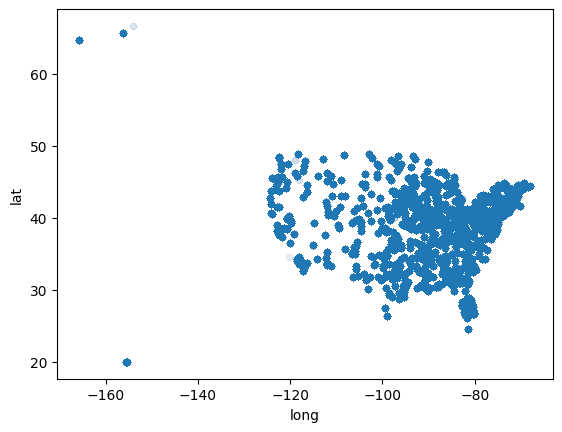

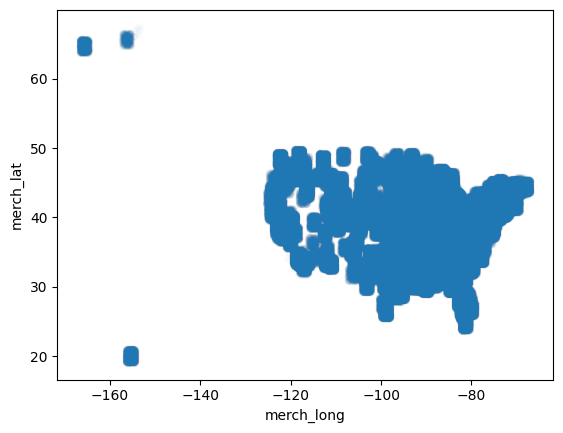

In [10]:
transactions_encoded.plot(kind="scatter", x="long", y="lat", alpha=0.01)
transactions_encoded.plot(kind="scatter", x="merch_long", y="merch_lat", alpha=0.01)
#Both the merchants and customers seem to be around the same country/state


array([[<Axes: title={'center': 'amt'}>]], dtype=object)

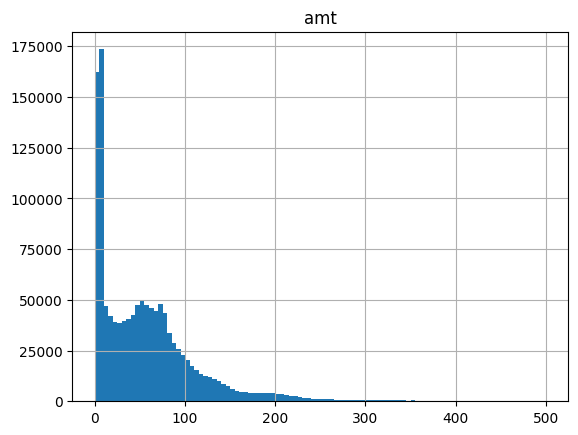

In [79]:
transactions_encoded.hist(column="amt", range=(0, 500), bins=100)
#The usual range of the amount transacted seems to be betwwen 0 and 500

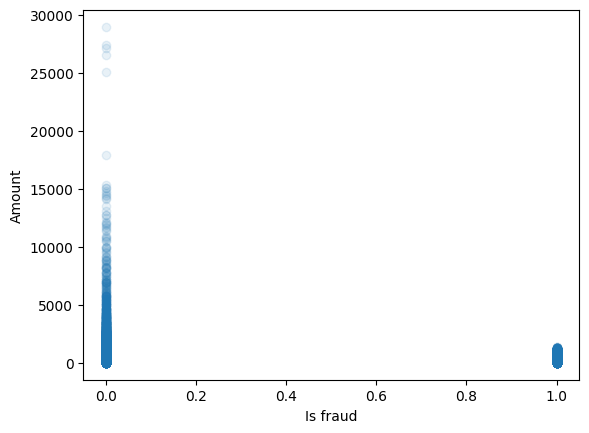

In [103]:
plt.scatter(transactions_encoded["is_fraud"], transactions_encoded["amt"], alpha=0.1)
plt.xlabel("Is fraud")
plt.ylabel("Amount")
plt.show()
#Contrary to what you'd expect, most frauds seem to not involve large sums of money

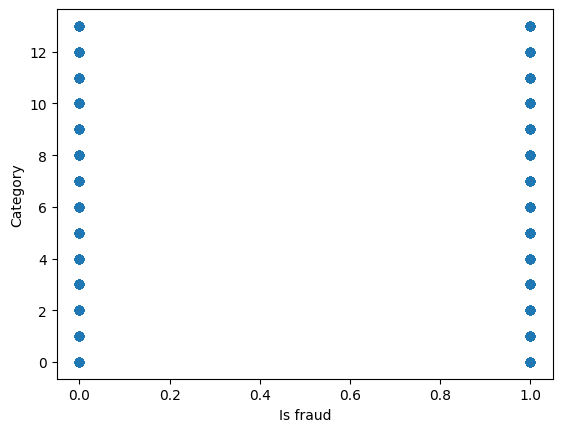

In [81]:
plt.scatter(transactions_encoded["is_fraud"], transactions_encoded["category"], alpha=0.1)
plt.ylabel("Category")
plt.xlabel("Is fraud")
plt.show()
#The distribution odds of fraud for each transaction category seems to be even

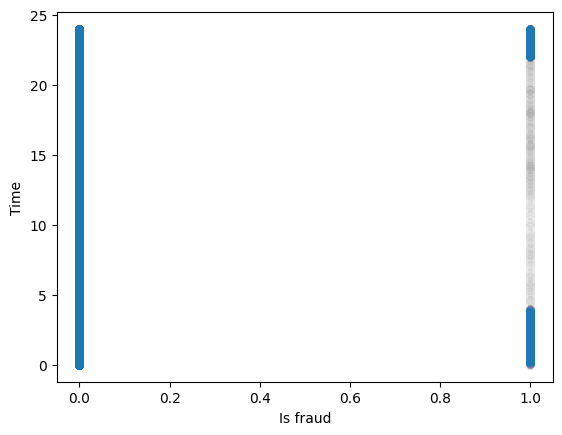

In [78]:
plt.scatter(transactions_encoded["is_fraud"], transactions_encoded["time"], alpha=0.002)
plt.xlabel("Is fraud")
plt.ylabel("Time")
plt.show()
#Most frauds seem to occur only between 10PM and 4AM, rather interesting

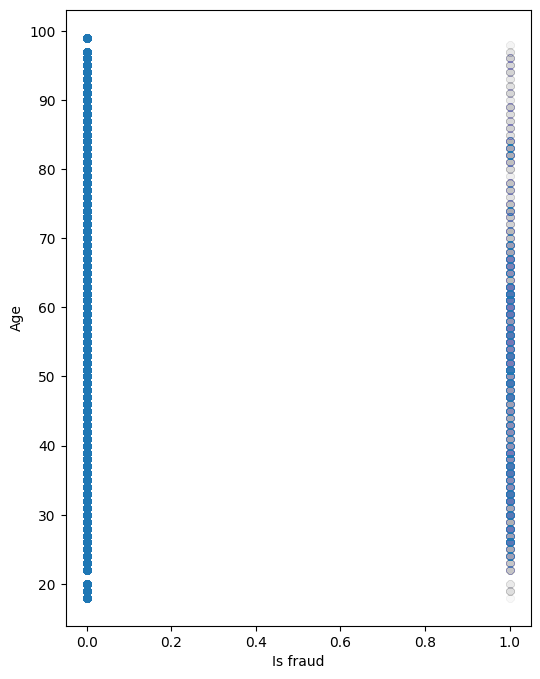

In [126]:
plt.figure(figsize=(6, 8)) 
plt.scatter(transactions_encoded["is_fraud"], transactions_encoded["age"], alpha=0.002)
plt.xlabel("Is fraud")
plt.ylabel("Age")
plt.show()
#The age bracket within which most fraud transactions seem to fall into is 50 to 65 followed by 30 to 40, but this could also be as a result of the fact that there aren't that many people over the age of 80

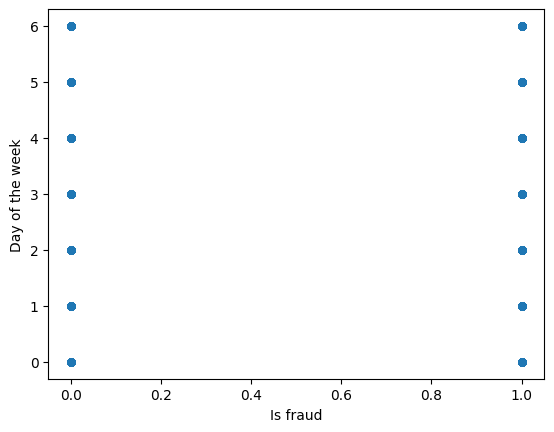

In [106]:
plt.scatter(transactions_encoded["is_fraud"], transactions_encoded["dow"], alpha=0.002)
plt.xlabel("Is fraud")
plt.ylabel("Day of the week")
plt.show()

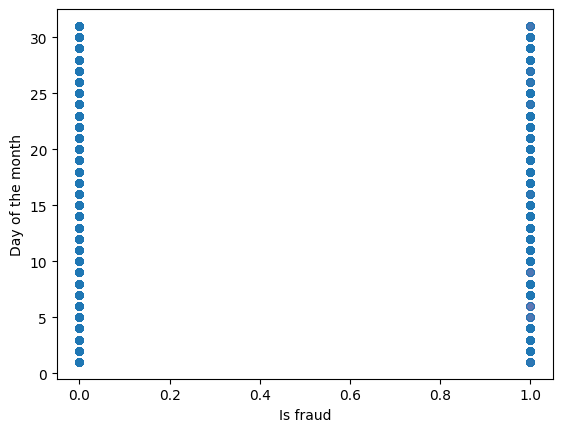

In [107]:
plt.scatter(transactions_encoded["is_fraud"], transactions_encoded["dom"], alpha=0.002)
plt.xlabel("Is fraud")
plt.ylabel("Day of the month")
plt.show()

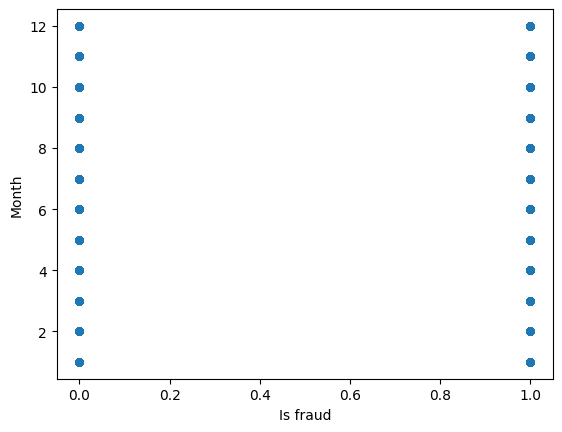

In [110]:
plt.scatter(transactions_encoded["is_fraud"], transactions_encoded["month"], alpha=0.002)
plt.xlabel("Is fraud")
plt.ylabel("Month")
plt.show()

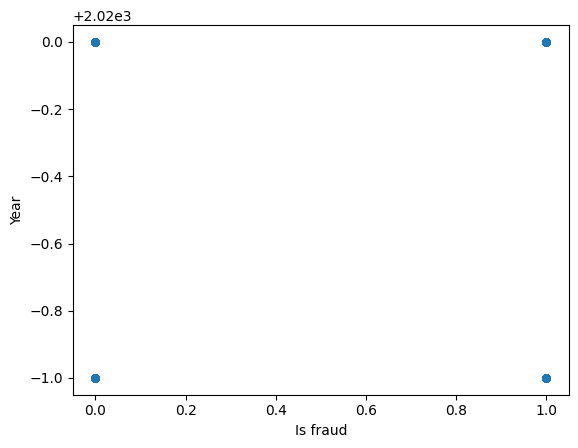

In [108]:
plt.scatter(transactions_encoded["is_fraud"], transactions_encoded["year"], alpha=0.002)
plt.xlabel("Is fraud")
plt.ylabel("Year")
plt.show()

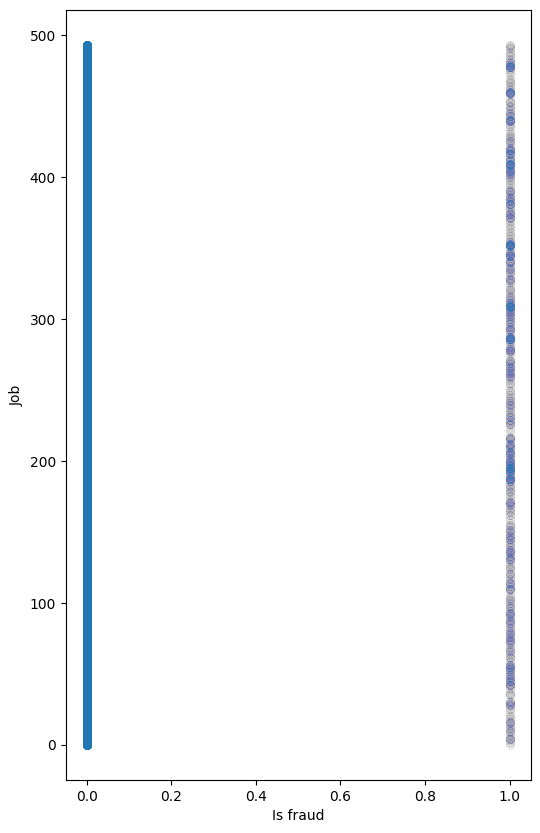

In [117]:
plt.figure(figsize=(6, 10))
plt.scatter(transactions_encoded["is_fraud"], transactions_encoded["job"], alpha=0.002)
plt.xlabel("Is fraud")
plt.ylabel("Job")
plt.show()
#Specific jobs seem more likely to experience fraud but only to a small degree

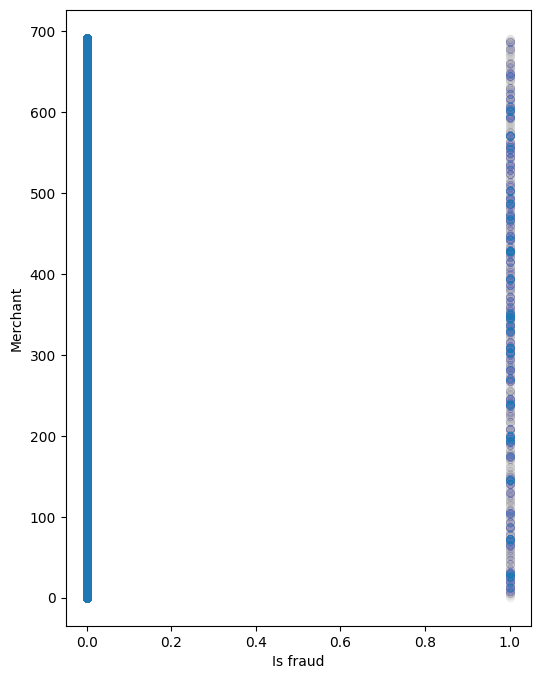

In [122]:
plt.figure(figsize=(6, 8))
plt.scatter(transactions_encoded["is_fraud"], transactions_encoded["merch_name"], alpha=0.002)
plt.xlabel("Is fraud")
plt.ylabel("Merchant")
plt.show()
#Specific transactions with specifc merchants seem to result a bit more to frauds

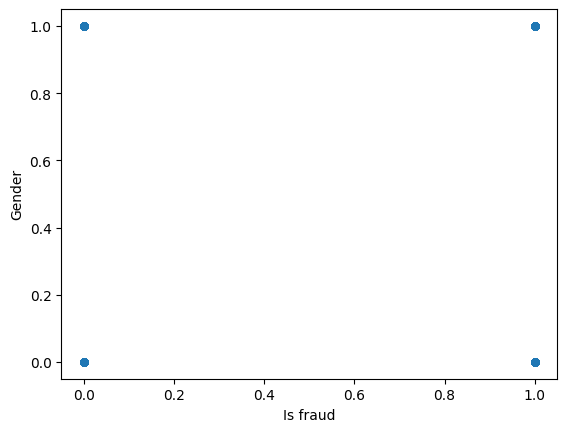

In [124]:
plt.scatter(transactions_encoded["is_fraud"], transactions_encoded["gender"], alpha=0.002)
plt.xlabel("Is fraud")
plt.ylabel("Gender")
plt.show()